In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)

In [2]:
# Build a SparkSession named as "test123"
spark = SparkSession.builder \
    .appName('test_123') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [3]:
sales = spark.read.parquet("./data/sales_parquet/")
products = spark.read.parquet("./data/products_parquet/")
sellers = spark.read.parquet("./data/sellers_parquet/")

In [4]:
combined = sales.join(products, on="product_id").join(sellers, on="seller_id")
combined.printSchema()

root
 |-- seller_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- num_pieces_sold: string (nullable = true)
 |-- bill_raw_text: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- price: string (nullable = true)
 |-- seller_name: string (nullable = true)
 |-- daily_target: string (nullable = true)



In [5]:
casted_combined = combined.select(
    combined["seller_id"].cast("int"),
    combined["product_id"].cast("int"),
    combined["date"],
    combined["num_pieces_sold"].cast("int"),
    combined["price"].cast("int"),
    combined["daily_target"].cast("int")
)
casted_combined.printSchema()

root
 |-- seller_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- num_pieces_sold: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- daily_target: integer (nullable = true)



In [7]:
casted_combined.count()

20000040

## Task-1: How many distinct products are sold each day?

In [6]:
sales.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- num_pieces_sold: string (nullable = true)
 |-- bill_raw_text: string (nullable = true)



In [9]:
dd = sales.select("date", "product_id").distinct().groupby("date").count()

dd

date,count
2020-07-03,100017
2020-07-07,99756
2020-07-01,100337
2020-07-08,99662
2020-07-04,99791
2020-07-10,98973
2020-07-09,100501
2020-07-06,100765
2020-07-02,99807
2020-07-05,99796


## Task-2: What is the average revenue of the orders?

In [31]:
from pyspark.sql.functions import mean as _mean, col

In [35]:
dd = casted_combined.\
    withColumn("total", casted_combined["num_pieces_sold"]*casted_combined["price"]).\
    select(_mean(col("total")))

In [36]:
dd.printSchema()

root
 |-- avg(total): double (nullable = true)



In [37]:
dd.show()

+------------------+
|        avg(total)|
+------------------+
|1246.1338560822878|
+------------------+



## Task-3: What is the average daily revenue of each product?

In [10]:
casted_combined.printSchema()

root
 |-- seller_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- num_pieces_sold: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- daily_target: integer (nullable = true)



In [61]:
sales.select("date").distinct().show()

+----------+
|      date|
+----------+
|2020-07-03|
|2020-07-07|
|2020-07-01|
|2020-07-08|
|2020-07-04|
|2020-07-10|
|2020-07-09|
|2020-07-06|
|2020-07-02|
|2020-07-05|
+----------+



In [76]:
dd = casted_combined.filter("date == '2020-07-03'").\
    withColumn("R", col("price")*col("num_pieces_sold")).\
    groupBy("date", "product_id").mean("R").\
    groupBy("product_id").mean("avg(R)").\
    withColumnRenamed("avg(avg(R))", "avg").\
    sort(desc("avg"))


In [77]:
dd.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- avg: double (nullable = true)



In [78]:
dd.limit(10).show()

+----------+-------+
|product_id|    avg|
+----------+-------+
|  13771931|15000.0|
|  18328448|15000.0|
|  18711217|15000.0|
|  19451022|15000.0|
|  61768749|15000.0|
|  62043848|15000.0|
|  59241451|14900.0|
|  57515495|14900.0|
|  15922094|14900.0|
|  35784427|14900.0|
+----------+-------+



## Task-4: For each seller, what is the average % contribution of an order to the sellers daily quota? 

In [126]:
import seaborn as sns

In [79]:
casted_combined.printSchema()

root
 |-- seller_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- num_pieces_sold: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- daily_target: integer (nullable = true)



In [124]:
ppp = casted_combined.\
    select("date", "seller_id", "daily_target").\
    groupby("date", "seller_id", "daily_target").count().\
    withColumn("contr", 100*col("count")/col("daily_target")).\
    groupby("seller_id").mean("contr").\
    sort(desc("avg(contr)"));

In [138]:
df4 = casted_combined.\
    select("date", "seller_id", "daily_target").\
    groupby("date", "seller_id", "daily_target").count().\
    withColumn("contr", 100*col("count")/col("daily_target")).\
    select("date", "seller_id", "contr").\
    sort(desc("seller_id"));
df4.printSchema()


root
 |-- date: string (nullable = true)
 |-- seller_id: integer (nullable = true)
 |-- contr: double (nullable = true)



In [172]:
import pandas as pd

In [204]:
pdf4 = df4.limit(100).toPandas()
pdf4_ = pdf4.copy();

In [219]:
pdf4 = pdf4_.copy()
pdf4["day"] = pdf4["date"].str[-2:].astype("int")
pdf4["seller_id"] = pdf4["seller_id"].astype("int")

In [229]:
from plotnine import ggplot, aes, facet_grid, facet_wrap, geom_line, geom_point

/opt/conda/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/opt/conda/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/opt/conda/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


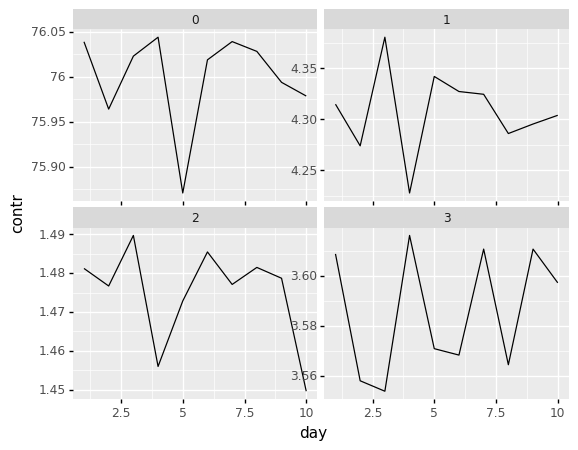

<ggplot: (8747039498454)>

In [233]:
(
 ggplot(pdf4.query("seller_id<4")) + aes(x="day", y="contr") + 
    geom_line() + facet_wrap("seller_id", scales="free")
)

In [251]:
sdf4 = df4.groupby("seller_id").agg(mean("contr"), stddev("contr")).sort(desc("avg(contr)")).select(
    col("seller_id"),
    format_number(col("avg(contr)"), 3).alias("avg"),
        format_number(col("stddev_samp(contr)"), 3).alias("std")
)
sdf4.printSchema()

root
 |-- seller_id: integer (nullable = true)
 |-- avg: string (nullable = true)
 |-- std: string (nullable = true)



In [252]:
sdf4.limit(10).show()

+---------+------+-----+
|seller_id|   avg|  std|
+---------+------+-----+
|        0|76.000|0.053|
|        1| 4.308|0.041|
|        3| 3.586|0.025|
|        8| 2.026|0.015|
|        2| 1.475|0.013|
|        6| 1.054|0.012|
|        5| 0.924|0.011|
|        9| 0.845|0.007|
|        4| 0.725|0.009|
|        7| 0.570|0.005|
+---------+------+-----+



## Task-5: Who are the second most selling and the least selling persons (sellers) for each product?

In [253]:
casted_combined.printSchema()

root
 |-- seller_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- num_pieces_sold: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- daily_target: integer (nullable = true)



In [320]:
df5 = (
        sales.select("product_id", "seller_id").distinct().groupby("product_id").count().sort(desc("count")).
        withColumnRenamed("count", "count_")
)
df5.printSchema()

root
 |-- product_id: string (nullable = true)
 |-- count_: long (nullable = false)



In [321]:
df5.groupby("count_").count()

count_,count
1,987603
3,21
2,5805


In [322]:
df5.filter("count_ == 3").limit(10)

product_id,count_
14542470,3
61475460,3
31136332,3
17944574,3
19986717,3
72017876,3
67723231,3
3534470,3
40496308,3
28592106,3


In [324]:
ooo = sales.filter("product_id == 14542470");

In [ ]:
ooo.limit(10)

In [317]:
df5.select("count").distinct()

count
1
3
2


In [267]:
from pyspark.sql.window import Window

In [268]:
w = Window.partitionBy("product_id");


In [278]:
df5 = (
    sales.
    groupby("seller_id", "product_id").count().
    withColumnRenamed("count", "count_").
    sort(desc("count"))
);
df5.printSchema()

root
 |-- seller_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- count_: long (nullable = false)



In [294]:
from pyspark.sql.functions import rank

In [296]:
w = Window.partitionBy(df5.product_id).orderBy(df5.count_)

In [300]:
atb = df5.withColumn("rank", rank().over(w)).sort(desc("count"))
atb.printSchema()

root
 |-- seller_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- count_: long (nullable = false)
 |-- rank: integer (nullable = false)



In [305]:
atb.filter("rank>1").show()

+---------+----------+------+----+
|seller_id|product_id|count_|rank|
+---------+----------+------+----+
|        4|   8916663|     2|   2|
|        5|  19978383|     2|   2|
|        8|  61540351|     2|   2|
|        8|   2316238|     2|   2|
|        7|  40193396|     2|   2|
|        1|  73385513|     2|   2|
|        9|  26915351|     2|   2|
|        9|  28183035|     2|   2|
|        1|   2839667|     2|   2|
|        8|  40579633|     2|   2|
+---------+----------+------+----+



In [310]:
sales.filter("product_id==0").select("product_id", "seller_id").distinct().count()

1

In [307]:
df5.filter("product_id == 8916663").show()

+---------+----------+------+
|seller_id|product_id|count_|
+---------+----------+------+
|        4|   8916663|     2|
|        5|   8916663|     1|
+---------+----------+------+



In [293]:
atb = df5.withColumn(
    "count", df5.count("*").over(w)
)

TypeError: count() takes 1 positional argument but 2 were given